## Create clean reference dataset

We have overlapping tiles and thus duplicates in the extracted reference data for those polygons which are located in the overlapping areas.

Since we do not want these duplicates and to make our life easier later we store the data such that:

* There are no duplicated extractions anymore.

* For a polygon that lives in overlapping areas we have to choose from which tile to take the data for the clean reference dataset.
  We include the polygon from the tile where the polygon is most far away from the raster border.

* We sort the pixels by the polygon id (and then the coordinates) such that pixels of the same polygon appear in one block.
  This might be useful later for loading the data from partitioning since often we want to have access to all pixels of a polygon. 

Note that the reference dataset is specific for a vector dataset and a set of tiles since the data changes if the overlapping areas change. 
In other words we cannot (necessarily) use the clean reference data of a specific tile created with four tiles for another clean reference dataset with another set of tiles surrounding the specific tile. 

In this notebook we assume that at least the auxiliary data of our full dataset fits in memory.

## Load packages, functions and configs

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# - - - - - - - - - - - - - - - - - - - - 
# DEFAULT IMPORTS - IN ALL NOTEBOKS
from src import configs

prjconf = configs.ProjectConfigParser()

# - - - - - - - - - - - - - - - - - - - - 
# NOTEBOOK SPECIFIC IMPORTS
import numpy as np
from pathlib import Path
import pandas as pd
import rasterio
import shutil
from tqdm import tqdm

    
from eobox.raster.extraction import load_extracted
from eobox.raster.extraction import load_extracted_partitions
from eobox.raster.extraction import convert_df_to_geodf
from eobox.raster.extraction import get_paths_of_extracted

tilenames = prjconf.get("Params", "tiles").split(" ")

tilenames =['32UNU', '32UPU', '32UQU', '33UUP', '32TPT', '32TQT', '33TUN']

print(tilenames)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['32UNU', '32UPU', '32UQU', '33UUP', '32TPT', '32TQT', '33TUN']


In [2]:
refset_id = "Refset00"
id_vectordata, tilenames = prjconf.get_clean_refset_parameters(refset_id)
dir_refset = prjconf.get_path(refset_id, "rootdir")

print("ALWAYS USE THESE THREE TOGETHER:")
print("id_vectordata  :", id_vectordata)
print("tilenames      :", tilenames)
print("dir_refset     :", dir_refset)

ALWAYS USE THESE THREE TOGETHER:
id_vectordata  : clc_lte50ha
tilenames      : ['32UNU', '32UPU', '32UQU', '33UUP']
dir_refset     : /home/ben/Devel/Projects/classify-hls/data/processed/refset00


## Auxiliary data

First we read the auxiliary data of all tiles as GeoDataFrame.

In [15]:
src_dirs_tiles

{'32UNU': PosixPath('/home/ben/Devel/Projects/classify-hls/data/processed/refset00/extracted/32UNU'),
 '32UPU': PosixPath('/home/ben/Devel/Projects/classify-hls/data/processed/refset00/extracted/32UPU'),
 '32UQU': PosixPath('/home/ben/Devel/Projects/classify-hls/data/processed/refset00/extracted/32UQU'),
 '33UUP': PosixPath('/home/ben/Devel/Projects/classify-hls/data/processed/refset00/extracted/33UUP')}

In [3]:
src_dirs_tiles = {tile:prjconf.get_path("Processed", "extracted", tile=tile) / 
                  prjconf.get_path("Raw", id_vectordata, tile=tile).stem for tile in tilenames}

df_aux = load_extracted_partitions(src_dirs_tiles, patterns=["aux_*.npy"], 
                                   to_crs={'init':'epsg:4326'}, verbosity=1)
print("Class :", df_aux.__class__)
print("CRS   :", df_aux.crs)
df_aux.head()

********************************************************************************
Loading partition 32UNU
- - - - - - - - - - - - - - - - - - - - 
Shape of partition dataframe: (1202365, 10)
Converting partition to GeoDataFrame.
Reprojecting GeoDataFrame to {'init': 'epsg:4326'}.
********************************************************************************
Loading partition 32UPU
- - - - - - - - - - - - - - - - - - - - 
Shape of partition dataframe: (1053593, 10)
Converting partition to GeoDataFrame.
Reprojecting GeoDataFrame to {'init': 'epsg:4326'}.
********************************************************************************
Loading partition 32UQU
- - - - - - - - - - - - - - - - - - - - 
Shape of partition dataframe: (1055108, 10)
Converting partition to GeoDataFrame.
Reprojecting GeoDataFrame to {'init': 'epsg:4326'}.
********************************************************************************
Loading partition 33UUP
- - - - - - - - - - - - - - - - - - - - 
Shape of parti

,inner_index,partition,aux_coord_x,aux_coord_y,aux_raster_dist2rb,aux_vector_Area_Ha,aux_vector_cid_l1,aux_vector_cid_l2,aux_vector_cid_l3,aux_vector_dist2pb,aux_vector_pid,geometry
0,0,32UNU,601725.0,5399955.0,1,25.511849,3,31,313,1.0,1067640,POINT (10.38372586549395 48.74430007510028)
1,1,32UNU,601755.0,5399955.0,1,25.511849,3,31,313,1.0,1067640,POINT (10.38413381957277 48.74429517496209)
2,2,32UNU,601725.0,5399925.0,2,25.511849,3,31,313,0.0,1067640,POINT (10.38371845737861 48.7440302733679)
3,3,32UNU,601755.0,5399925.0,2,25.511849,3,31,313,1.0,1067640,POINT (10.38412640927505 48.74402537327593)
4,4,32UNU,601785.0,5399925.0,2,25.511849,3,31,313,1.0,1067640,POINT (10.38453436106155 48.74402047174017)


Given a polygon appears more often (due to overlapping areas) we want to keep the polygon from the tile where the minimum of the polygon's pixel distancees is highest.

In [4]:
df_polys_duplicates = df_aux.loc[df_aux.groupby(["partition", "aux_vector_pid"])["aux_raster_dist2rb"].idxmin()]
df_polys_duplicates.head()

,inner_index,partition,aux_coord_x,aux_coord_y,aux_raster_dist2rb,aux_vector_Area_Ha,aux_vector_cid_l1,aux_vector_cid_l2,aux_vector_cid_l3,aux_vector_dist2pb,aux_vector_pid,geometry
1016355,1016355,32UNU,556035.0,5307525.0,577,39.756351,1,11,111,0.0,1036597,POINT (9.750007739982269 47.91859797279565)
850934,850934,32UNU,523635.0,5321955.0,788,49.029782,1,11,111,0.0,1036605,POINT (9.317151595503656 48.05043913255241)
752819,752819,32UNU,545385.0,5332485.0,1409,43.890628,1,11,111,0.0,1036615,POINT (9.610115706518565 48.14399629570883)
574869,574869,32UNU,554115.0,5348295.0,1723,38.386208,1,11,111,0.0,1036622,POINT (9.72948267511029 48.28554214105441)
427128,427128,32UNU,571275.0,5360625.0,1283,26.731875,1,11,111,0.0,1036627,POINT (9.96286031263905 48.39475544458947)


Count the frequency of the number of polygon ID duplicates.

It makes sense if most of the polygons appear only once and if duplications are higher number of polygons affected is lower.

In [6]:
df_polys_duplicates["aux_vector_pid"].value_counts().value_counts()

1    7263
2    1952
Name: aux_vector_pid, dtype: int64

Lets get a unique set of polygon IDs distributed over the tiles.
We select the polygon from the tile where the polygon is most far away from the tile border.

We already have the closest distance between all pixels of a polygons to the tile border.
Now we select the polygon of the tile where this minimum distance is largest.

In [7]:
df_polys_unique = df_polys_duplicates.groupby("aux_vector_pid").apply(lambda x: x.loc[[x["aux_raster_dist2rb"].idxmax()]])
df_polys_unique["aux_vector_pid"].value_counts().value_counts()

1    9215
Name: aux_vector_pid, dtype: int64

Lets store the point file.

In [10]:
fname_centroids_unique = prjconf.get_path("Refset00", "rootdir") / \
    f"unique_polygon_centroids__{id_vectordata}__{'-'.join(tilenames)}.gpkg"
fname_centroids_unique.parent.mkdir(exist_ok=True, parents=True)
print(fname_centroids_unique)
df_polys_unique["partition"] = df_polys_unique["partition"].astype(str)
df_polys_unique.to_file(fname_centroids_unique, driver='GPKG')

/home/ben/Devel/Projects/classify-hls/data/processed/refset00/unique_polygon_centroids__clc_lte50ha__32UNU-32UPU-32UQU-33UUP.gpkg


Now we can get the indices per tile such that we do not have any duplicates anymore in the pixels we load.

In [11]:
indices = {}
for tile in tilenames:
    df = df_aux[df_aux["partition"] == tile]
    df = df.set_index("inner_index")
    df_polys_unique_this_tile = df_polys_unique["partition"] == tile
    # df = df[df["aux_vector_pid"].isin(df_polys_unique[df_polys_unique_this_tile].aux_vector_pid.values)]
    # print(df.shape)
    # print(f"Number of all / unique pixels: {df_aux[df_aux['partition'] == tile].shape[0]} / {len(indices[tile])}.")
    indices[tile] = df["aux_vector_pid"].isin(df_polys_unique[df_polys_unique_this_tile].aux_vector_pid.values)
    print(f"Number of all / unique pixels: {len(indices[tile])} / {indices[tile].sum()}.")
    
    # df["partition"] = df["partition"].astype(str)
    # df.to_file("__df_pixels_32UNU.gpkg", driver='GPKG')

Number of all / unique pixels: 1202365 / 1165071.
Number of all / unique pixels: 1053593 / 973223.
Number of all / unique pixels: 1055108 / 702019.
Number of all / unique pixels: 1032643 / 745600.


**BUT ...** to makes things easier and get not confused with all the indexing we store the subsets separately.

Furthermore, as we see from the first polygon the pixels of one polygon are not necessarily stored in adjacent rows.
It somehow makes sense to do so.

So lets sort when we anyway store the data again.

In [12]:
index_next = 0
overwrite = False    
for tile in tqdm(tilenames, total=len(tilenames)):
    # directory and paths of the initially extracted data (with duplicates due to overlap)
    dir_extracted = prjconf.get_path("Processed", "extracted", tile) / prjconf.get_path("Raw", id_vectordata, tile=tile).stem
    paths_extracted = get_paths_of_extracted(dir_extracted)
    # directory of the clean refset
    dir_extracted_refset = prjconf.get_path("Refset00", "extracted", tile)
    dir_extracted_refset.mkdir(exist_ok=True, parents=True)
    
    # index of pixels with keep and the columns we sort by 
    index = indices[tile]
    cols_sort = ['aux_vector_pid', 'aux_coord_y', 'aux_coord_x']
    
    # load the aux data
    df = load_extracted(dir_extracted, [col + "*.npy" for col in cols_sort], index=index)
    df_sorted = df.sort_values(cols_sort)

    # create the global index - sequential numbering without gaps and unique over all tiles
    aux_index_global = np.array((range(index_next, index_next+index.sum())))
    assert len(aux_index_global) == index.sum()
    path_dst = dir_extracted_refset / "aux_index_global.npy"
    np.save(path_dst, aux_index_global)
    # we start with this index in the next tile
    index_next = aux_index_global[-1] + 1
    
    # load and re-save the ordered subsets of all features
    for path in paths_extracted:
        colname_src = path.stem
        path_dst = dir_extracted_refset / colname_src.replace(tile.lower()+'__', '')
        if not path_dst.exists() or overwrite:
            # in the destination lets get rid of the tile in the filename
            # this is disturbing later when we get the data
            df_feature = load_extracted(dir_extracted, colname_src + '*.npy', index=index)
            df_feature = df_feature.loc[df_sorted.index]
            np.save(path_dst, df_feature.iloc[:,0].values)
            
    tifs = get_paths_of_extracted(dir_extracted, "*.tif")
    for tif in tifs:
        shutil.copy(tif, dir_extracted_refset / tif.name)
    
    # load_extracted(dir_extracted_refset, "aux_*.npy")


100%|██████████| 4/4 [00:31<00:00,  8.46s/it]


Try to load the new data.

In [13]:
src_dirs_tiles = {tile: prjconf.get_path("Refset00", "extracted", tile=tile) for tile in tilenames}

df_aux = load_extracted_partitions(src_dirs_tiles, patterns=["aux_*.npy"], 
                                   to_crs={'init':'epsg:4326'}, verbosity=1)
print("Class :", df_aux.__class__)
print("CRS   :", df_aux.crs)
df_aux.head()

********************************************************************************
Loading partition 32UNU
- - - - - - - - - - - - - - - - - - - - 
Shape of partition dataframe: (1165071, 11)
Converting partition to GeoDataFrame.
Reprojecting GeoDataFrame to {'init': 'epsg:4326'}.
********************************************************************************
Loading partition 32UPU
- - - - - - - - - - - - - - - - - - - - 
Shape of partition dataframe: (973223, 11)
Converting partition to GeoDataFrame.
Reprojecting GeoDataFrame to {'init': 'epsg:4326'}.
********************************************************************************
Loading partition 32UQU
- - - - - - - - - - - - - - - - - - - - 
Shape of partition dataframe: (702019, 11)
Converting partition to GeoDataFrame.
Reprojecting GeoDataFrame to {'init': 'epsg:4326'}.
********************************************************************************
Loading partition 33UUP
- - - - - - - - - - - - - - - - - - - - 
Shape of partiti

,inner_index,partition,aux_coord_x,aux_coord_y,aux_index_global,aux_raster_dist2rb,aux_vector_Area_Ha,aux_vector_cid_l1,aux_vector_cid_l2,aux_vector_cid_l3,aux_vector_dist2pb,aux_vector_pid,geometry
0,0,32UNU,556035.0,5307525.0,0,577,39.756351,1,11,111,0.0,1036597,POINT (9.750007739982269 47.91859797279565)
1,1,32UNU,556065.0,5307525.0,1,577,39.756351,1,11,111,1.0,1036597,POINT (9.750409243253404 47.91859534979572)
2,2,32UNU,556095.0,5307525.0,2,577,39.756351,1,11,111,1.0,1036597,POINT (9.750810746467339 47.91859272539219)
3,3,32UNU,556125.0,5307525.0,3,577,39.756351,1,11,111,0.0,1036597,POINT (9.751212249624043 47.91859009958505)
4,4,32UNU,556155.0,5307525.0,4,577,39.756351,1,11,111,0.0,1036597,POINT (9.751613752723483 47.91858747237428)


And store all the points with auxiliary info as GeoPackage.

In [14]:
print(prjconf.get_path("Refset00", "rootdir") / "extracted_aux.gpkg")
df_aux.to_file(prjconf.get_path("Refset00", "rootdir") / "extracted_aux.gpkg", driver="GPKG")

/home/ben/Devel/Projects/classify-hls/data/processed/refset00/extracted_aux.gpkg


## AND THEN THE WHOLE WITH DASK

**TODO - finalize this...**

In [12]:
import numpy as np
import dask.delayed
from dask import delayed
import dask.dataframe as dd

@delayed
def _load_column(path, index=None):
    """Load a single dataframe column given a numpy file path."""
    if index is None:
        arr = np.load(str(path), allow_pickle=True)
    else:
        arr = np.load(str(path), mmap_mode="r", allow_pickle=True)[index]
    df = pd.DataFrame(arr)
    df.columns = [path.stem]
    return df

@delayed
def _concat_columns(column_list):
    """Concatenate single dataframe columns."""
    return pd.concat(column_list, axis=1)
    

# @delayed
def load_extracted_dask(npy_path_list):
    column_list = []
    for npy_path in npy_path_list:
        column_list.append(_load_column(npy_path))
    df = _concat_columns(column_list)
    df = dd.from_delayed(df)
    return df
        # df_data[path.stem] = _load_column(path, index)
        #if index is not None:
        #    df_data.index = index.index[index]

# _load(npy_path, index_29)

#df = get_df(npy_path_stack)
#df.compute()

for i, tile in enumerate(tilenames): 
    print(tile, " - first file")
    if i == 0:
        ddf = load_extracted_dask(paths_npy[tile])
    else:
        ddf.append(load_extracted_dask(paths_npy[tile]))
ddf

32UNU  - first file
32UPU  - first file
32UQU  - first file
33UUP  - first file


,32unu__scoll01__vts4w__2018-05-27__NIR,32unu__scoll01__vts4w__2018-05-27__Red,aux_coord_x,32unu__scoll01__vts4w__2018-04-29__NIR,32unu__scoll01__vts4w__2018-01-07__SWIR2,32unu__scoll01__vts4w__2018-09-16__Red,32unu__scoll01__vts4w__2018-07-22__SWIR2,32unu__scoll01__vts4w__2018-08-19__SWIR2,32unu__scoll01__vts4w__2018-02-04__NIR,32unu__scoll01__vts4w__2018-02-04__SWIR1,aux_vector_cid_l3,32unu__scoll01__vts4w__2018-03-04__SWIR1,32unu__scoll01__vts4w__2018-04-29__SWIR1,32unu__scoll01__vts4w__2018-07-22__Red,32unu__scoll01__vts4w__2018-11-11__SWIR1,32unu__scoll01__vts4w__2018-04-01__SWIR2,32unu__scoll01__vts4w__2018-04-01__NIR,32unu__scoll01__vts4w__2018-10-14__SWIR1,32unu__scoll01__vts4w__2018-05-27__SWIR2,32unu__scoll01__vts4w__2018-08-19__NIR,32unu__scoll01__vts4w__2018-04-29__Red,32unu__scoll01__vts4w__2018-03-04__SWIR2,32unu__scoll01__vts4w__2018-01-07__Red,32unu__scoll01__vts4w__2018-11-11__Red,aux_vector_cid_l1,32unu__scoll01__vts4w__2018-11-11__NIR,32unu__scoll01__vts4w__2018-04-29__SWIR2,32unu__scoll01__vts4w__2018-07-22__NIR,32unu__scoll01__vts4w__2018-09-16__SWIR1,32unu__scoll01__vts4w__2018-08-19__Red,aux_vector_dist2pb,32unu__scoll01__vts4w__2018-11-11__SWIR2,32unu__scoll01__vts4w__2018-07-22__SWIR1,32unu__scoll01__vts4w__2018-06-24__SWIR2,32unu__scoll01__vts4w__2018-03-04__Red,32unu__scoll01__vts4w__2018-05-27__SWIR1,aux_coord_y,32unu__scoll01__vts4w__2018-10-14__NIR,32unu__scoll01__vts4w__2018-12-09__Red,32unu__scoll01__vts4w__2018-01-07__SWIR1,32unu__scoll01__vts4w__2018-03-04__NIR,32unu__scoll01__vts4w__2018-04-01__Red,32unu__scoll01__vts4w__2018-10-14__Red,32unu__scoll01__vts4w__2018-01-07__NIR,32unu__scoll01__vts4w__2018-08-19__SWIR1,32unu__scoll01__vts4w__2018-04-01__SWIR1,32unu__scoll01__vts4w__2018-09-16__NIR,32unu__scoll01__vts4w__2018-10-14__SWIR2,32unu__scoll01__vts4w__2018-06-24__SWIR1,aux_vector_cid_l2,32unu__scoll01__vts4w__2018-12-09__SWIR1,32unu__scoll01__vts4w__2018-12-09__SWIR2,aux_raster_dist2rb,32unu__scoll01__vts4w__2018-02-04__Red,32unu__scoll01__vts4w__2018-02-04__SWIR2,32unu__scoll01__vts4w__2018-06-24__NIR,aux_vector_pid,aux_vector_area,32unu__scoll01__vts4w__2018-12-09__NIR,32unu__scoll01__vts4w__2018-06-24__Red,32unu__scoll01__vts4w__2018-09-16__SWIR2
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int16,int16,float64,int16,int16,int16,int16,int16,int16,int16,int64,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int64,int16,int16,int16,int16,int16,float32,int16,int16,int16,int16,int16,float64,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int64,int16,int16,uint16,int16,int16,int16,int64,float64,int16,int16,int16
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
df = ddf.compute()
df.shape

(1622277, 61)

In [24]:
paths_npy_tile = paths_npy["32UNU"]

In [ ]:
import dask

In [ ]:
dask_arrays = []
for fn in paths_npy_tile:
    f = np.fromfile(str(fn))
    array = da.from_array(f, chunks=(1000, 1000))
    dask_arrays.append(array)

### Files

In [3]:
path_ref_vector_all_tiles = {}
for tile in tilenames:
    path_ref_vector_all_tiles[tile] = prjconf.get_path("Interim", "clc_subset5", tile=tile)
    assert path_ref_vector_all_tiles[tile].exists()
    print(path_ref_vector_all_tiles[tile])

paths_raster_all_tiles = {}
for tile in tilenames:
    paths_raster_all_tiles[tile] = prjconf.get_paths_features_vts_regular_raster(
        scoll_name, tile, variables, idx_virtual, as_dict=False)

/home/ben/Devel/Projects/classify-hls/data/interim/clc/clc2018_32UNU_subset_500000.gpkg
/home/ben/Devel/Projects/classify-hls/data/interim/clc/clc2018_32UPU_subset_500000.gpkg
/home/ben/Devel/Projects/classify-hls/data/interim/clc/clc2018_32UQU_subset_500000.gpkg
/home/ben/Devel/Projects/classify-hls/data/interim/clc/clc2018_33UUP_subset_500000.gpkg


## EDA

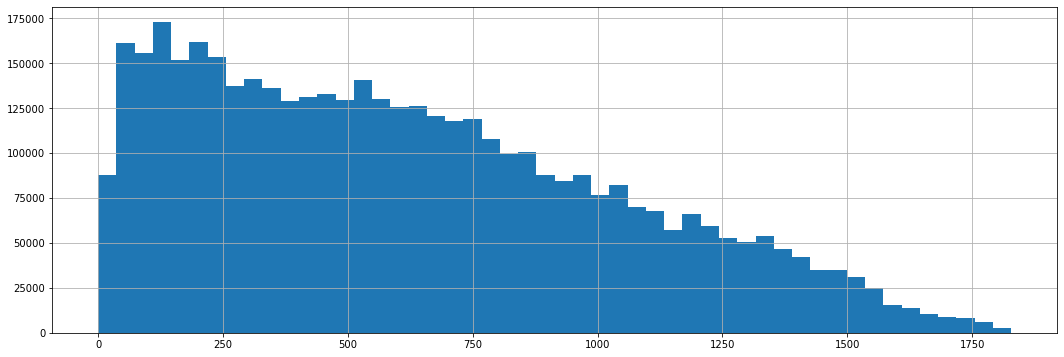

In [78]:
# distance to raster border
# it makes sense that there are more pixels close to the raster border
df_aux.aux_raster_dist2rb.hist(bins=50, figsize=(18, 6))